In [ ]:
import torch
from torch import nn
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

# 批量规范化

## 为什么需要批量规范化？

- 数据预处理的方式通常会对最终结果产生巨大影响。一般对输入数据进行标准化处理，可以统一特征数据的量级

- 对于典型的多层感知机或卷积神经网络，在训练时，中间层中的变量可能具有更广的变化范围
    - 被称作**输入分布偏移**（internal convariate shift）

<center><img src="../img/6_convolutional_neural_networks/internalCovariateShift.gif" width=80%></center>

- 更深层的网络很复杂，容易过拟合

- 批量规范化（Batch Normalization）是一种流行且有效的技术，可持续加速深层网络的收敛速度

## 批量规范化层

### 原理

- 原理：在每次训练迭代中，
    - 首先规范化输入，即通过减去其均值并除以其标准差，其中两者均基于当前小批量处理。
    - 接下来，应用比例系数和比例偏移。

- $\mathbf{x} \in \mathcal{B}$表示一个来自小批量$\mathcal{B}$的输入，批量规范化$\mathrm{BN}$根据以下表达式转换$\mathbf{x}$
- 固定小批量里面的均值和方差
$$\mu_B = \frac{1}{|B|}\sum_{i\in B} x_i  \space , \space \sigma_B^2 = \frac{1}{|B|}\sum_{i\in B} (x_i-\mu_B)^2 +\varepsilon$$

其中，$\varepsilon$是一个非常小的正数，防止$\sigma_B=0$

- 然后再做额外的调整
$$ x_{i+1} = \gamma * \frac{x_i-\mu_B}{\sigma_B}+\beta$$

- 可学习的参数为$\gamma$（拉伸） 和 $\beta$（偏移）

- 拉伸和偏移的目的
    - 维持网络的表达能力
    - 降低训练复杂度：批量规范化之前，某一隐藏层的输出取决于之前隐藏层的复杂关联；批量规范化之后，输出均值仅由$\beta$决定

### 批量规范化层的位置

#### 全连接层

- 通常将批量规范化层置于全连接层中的线性变换和激活函数之间。

设全连接层的输入为x，权重参数和偏置参数分别为$\mathbf{W}$和$\mathbf{b}$，激活函数为$\phi$，批量规范化的运算符为$\mathrm{BN}$。
那么，使用批量规范化的全连接层的输出的计算如下：

$$\mathbf{h} = \phi(\mathrm{BN}(\mathbf{W}\mathbf{x} + \mathbf{b}) ).$$

- 对全连接层，批量规范化作用在**特征维**

<center><img src="../img/6_convolutional_neural_networks/BNPos.jpg" width=60%></center>

#### 卷积层

- 对于卷积层，可以在卷积层之后和非线性激活函数之前应用批量规范化
- 当卷积有多个输出通道时，需要对这些通道的“每个”输出执行批量规范化，每个通道都有自己的拉伸（scale）和偏移（shift）参数

- 对于卷积层，批量规范化作用在**通道维**

<center><img src="../img/6_convolutional_neural_networks/convBN1.png" width=100%></center>

- 卷积中批量规范化的计算图示

<center><img src="../img/6_convolutional_neural_networks/convBN.png" width=60%></center>

> 使用批量规范化要求批量不能过小

### 预测过程中的批量规范化

- 将训练好的模型用于预测时，不再需要样本均值中的噪声以及估计每个小批次产生的样本方差

- 通过移动平均估算整个训练数据集的样本均值和方差，并在预测时使用它们得到确定的输出

## 从零实现

In [1]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # 通过is_grad_enabled来判断当前模式是训练模式还是预测模式
    if not torch.is_grad_enabled():
        # 如果是在预测模式下，直接使用传入的移动平均所得的均值和方差
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4) # 2是全连接，4是二维卷积
        if len(X.shape) == 2: 
            # 使用全连接层的情况，计算特征维上的均值和方差
            mean = X.mean(dim=0)  
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # 使用二维卷积层的情况，计算通道维上（axis=1）的均值和方差。
            # 这里我们需要保持X的形状以便后面可以做广播运算
            mean = X.mean(dim=(0, 2, 3), keepdim=True) # shape：1*n*1*1
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # 训练模式下，用当前的均值和方差做标准化
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # 更新移动平均的均值和方差
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta  # 缩放和移位
    return Y, moving_mean.data, moving_var.data

- 创建一个正确的`BatchNorm`层

In [2]:
class BatchNorm(nn.Module):
    # num_features：完全连接层的输出数量或卷积层的输出通道数。
    # num_dims：2表示完全连接层，4表示卷积层
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # 参与求梯度和迭代的拉伸和偏移参数，分别初始化成1和0
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # 非模型参数的变量初始化为0和1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # 如果X不在内存上，将moving_mean和moving_var复制到X所在显存上
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # 保存更新过的moving_mean和moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.9)
        return Y

- 应用`BatchNorm`于LeNet模型

In [3]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10))

- 在Fashion-MNIST数据集上训练网络

In [ ]:
import sys
sys.path.append('/home/teaching/slides/deeplearning/3_linear_network')
sys.path.append('/home/teaching/slides/deeplearning/6_convolutional_neural_networks')
# 将load_data_fashion_mnist函数所在路径加入系统环境变量路径中

from softmax_regression_scratch import load_data_fashion_mnist, Accumulator, Animator, accuracy
from convolution_LeNet import train_ch6, try_gpu

In [4]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)
train_ch6(net, train_iter, test_iter, num_epochs, lr, try_gpu())

loss 0.268, train acc 0.900, test acc 0.831
38739.6 examples/sec on cuda:0


- 查看拉伸参数`gamma`和偏移参数`beta`

In [5]:
net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))

(tensor([0.3362, 4.0349, 0.4496, 3.7056, 3.7774, 2.6762], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>),
 tensor([-0.5739,  4.1376,  0.5126,  0.3060, -2.5187,  0.3683], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>))

### 简洁实现

In [6]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(256, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10))

```python
torch.nn.BatchNorm2d(num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, device=None, dtype=None)
```
- 适用于卷积层的规范化，即对四维张量（批量、通道、高、宽）数据规范化
- `num_features`：输入通道数
- `track_running_stats`：当为`True`时，在训练时会始终记录并更新（通过动量方法更新）全局的均值和方差，然后在检验时可以用这个均值和方差来归一化。当为`False`时，不记录更新全局的均值和方差，检验时用检验数据本身的均值和方差来归一化
- `momentum`：是训练过程中对均值和方差进行动量更新的动量参数；在`track_running_stats`为`False`时，`momentum`不起作用
- `affine`：当为`True`时，$\gamma$和$\beta$参数是可学习的；反之，是不可学习的

```python
torch.nn.BatchNorm1d(num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, device=None, dtype=None)
```
- 适用于全连接层的规范化，即对二维张量（批量，特征数量）数据规范化

- 使用相同超参数来训练模型

loss 0.269, train acc 0.901, test acc 0.853
64557.2 examples/sec on cuda:0


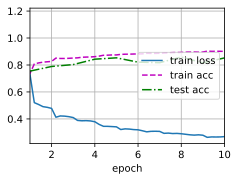

In [7]:
train_ch6(net, train_iter, test_iter, num_epochs, lr, try_gpu())

## 为什么要使用批量归一化？

这是一个开放性的问题
- 最初想用它来减少内部协变量转移
- 训练过程中由于使用mini-batch的mean/variance作为总体样本统计量估计，引入了随机噪声，在一定程度上对模型起到了正则化的效果。
- 没有必要跟dropout混合使用
- 缓解了梯度传递问题，以及饱和非线性激活问题，通过平滑优化解空间，起到了正则化作用，使模型对大步长学习率敏感度降低，更加易于训练


- 左侧：损失的变动 $L(x+\lambda\nabla L(x))$
- 右侧：损失梯度的变动 $||\nabla L(x)-\nabla L(x+\lambda\nabla L(x))||$

<center><img src="../img/6_convolutional_neural_networks/BNlandscapes.jpg" width=100%></center>

- 批量规范化使得损失变动和损失梯度变动更加稳定，允许更大的学习率，进而实现更加平滑的优化过程